In [6]:
import gzip
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import csv
import json
from sklearn.model_selection import train_test_split

## Data Cleaning 

### Convert CSV to Json

In [7]:
# def csv_to_json(csvFilePath, jsonFilePath):
#     data = {}
#     with open(csvFilePath, encoding='utf-8') as csvf:
#         csvReader = csv.DictReader(csvf)
#         for rows in csvReader:
#             key = rows['No']
#             data[key] = rows
#     with open(jsonFilePath, 'w', encoding='utf-8') as jsonf:
#         jsonf.write(json.dumps(data, indent=4))
# csv_to_json(r'100k_a.csv', r'100k_a.json')

In [29]:
df = pd.read_csv('100k_a.csv', header=None)
df = df.rename(columns={0: 'user_id', 1: 'stream_id', 2: 'streamer_name', 3: 'start_time', 4: 'stop_time'})
df

,user_id,stream_id,streamer_name,start_time,stop_time
0,1,33842865744,mithrain,154,156
1,1,33846768288,alptv,166,169
2,1,33886469056,mithrain,587,588
3,1,33887624992,wtcn,589,591
4,1,33890145056,jrokezftw,591,594
...,...,...,...,...,...
3051728,100000,34167930576,mckytv,3582,3583
3051729,100000,34168288656,natehill,3582,3583
3051730,100000,34169594512,fortnite,3582,3584
3051731,100000,34180223072,highdistortion,3709,3711


In [34]:
df['user_id'].nunique()

100000

In [35]:
df.isna().sum() # check for NAs

user_id          0
stream_id        0
streamer_name    0
start_time       0
stop_time        0
time_spent       0
dtype: int64

In [30]:
# Start and stop times are provided as integers and represent periods of 10 minutes.
df['start_time'] = df['start_time'] * 10
df['stop_time'] = df['stop_time'] * 10

In [31]:
# convert minutes to hours
df['time_spent'] = df['stop_time'] - df['start_time']

In [45]:
df

,user_id,stream_id,streamer_name,start_time,stop_time,time_spent
0,1,33842865744,mithrain,1540,1560,20
1,1,33846768288,alptv,1660,1690,30
2,1,33886469056,mithrain,5870,5880,10
3,1,33887624992,wtcn,5890,5910,20
4,1,33890145056,jrokezftw,5910,5940,30
...,...,...,...,...,...,...
3051728,100000,34167930576,mckytv,35820,35830,10
3051729,100000,34168288656,natehill,35820,35830,10
3051730,100000,34169594512,fortnite,35820,35840,20
3051731,100000,34180223072,highdistortion,37090,37110,20


In [43]:
df['time_spent'].value_counts()

time_spent
10     1559891
20      498252
30      263958
40      168944
50      115769
        ...   
800          2
900          2
780          1
970          1
810          1
Name: count, Length: 86, dtype: int64

## EDA

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3051733 entries, 0 to 3051732
Data columns (total 6 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   user_id        int64 
 1   stream_id      int64 
 2   streamer_name  object
 3   start_time     int64 
 4   stop_time      int64 
 5   time_spent     int64 
dtypes: int64(5), object(1)
memory usage: 139.7+ MB


In [38]:
df.describe()

,user_id,stream_id,start_time,stop_time,time_spent
count,3.051733e+06,3.051733e+06,3.051733e+06,3.051733e+06,3.051733e+06
mean,5.032313e+04,3.413002e+10,3.146044e+04,3.149186e+04,3.142054e+01
std,2.889476e+04,1.682242e+08,1.772520e+04,1.772656e+04,4.257966e+01
min,1.000000e+00,3.380153e+10,0.000000e+00,1.000000e+01,1.000000e+01
25%,2.528400e+04,3.398884e+10,1.618000e+04,1.620000e+04,1.000000e+01
50%,5.029900e+04,3.413069e+10,3.174000e+04,3.178000e+04,1.000000e+01
75%,7.545200e+04,3.427399e+10,4.676000e+04,4.679000e+04,3.000000e+01
max,1.000000e+05,3.441642e+10,6.147000e+04,6.148000e+04,9.700000e+02


In [58]:
# shuffle dataframe
df = df.sample(frac=1, random_state=42)  
df
# train, test = train_test_split(df, test_size=0.3)
# train

,user_id,stream_id,streamer_name,start_time,stop_time,time_spent
1808179,59782,33840590320,trolljac,1170,1180,10
2799087,92004,34336740304,jay_savage95,52940,52950,10
2371948,78196,34129227424,roxyproxxy,31740,31750,10
1980604,65429,34058759456,mckytv,23980,23990,10
189599,6481,34218567872,kjh203520,41070,41120,50
...,...,...,...,...,...,...
1692743,55852,34264603520,pathra,45810,45820,10
2356330,77691,33924007184,nickchipperhs,9550,9560,10
2229084,73472,34314206832,marinagostadegirassol,50460,50470,10
2768307,91051,34146677840,tipsyburbles,33400,33470,70


In [59]:
# convert df to list of json
data = df.to_dict(orient='records')
data

[{'user_id': 59782,
  'stream_id': 33840590320,
  'streamer_name': 'trolljac',
  'start_time': 1170,
  'stop_time': 1180,
  'time_spent': 10},
 {'user_id': 92004,
  'stream_id': 34336740304,
  'streamer_name': 'jay_savage95',
  'start_time': 52940,
  'stop_time': 52950,
  'time_spent': 10},
 {'user_id': 78196,
  'stream_id': 34129227424,
  'streamer_name': 'roxyproxxy',
  'start_time': 31740,
  'stop_time': 31750,
  'time_spent': 10},
 {'user_id': 65429,
  'stream_id': 34058759456,
  'streamer_name': 'mckytv',
  'start_time': 23980,
  'stop_time': 23990,
  'time_spent': 10},
 {'user_id': 6481,
  'stream_id': 34218567872,
  'streamer_name': 'kjh203520',
  'start_time': 41070,
  'stop_time': 41120,
  'time_spent': 50},
 {'user_id': 32499,
  'stream_id': 33841673040,
  'streamer_name': 'teeqzy_',
  'start_time': 1270,
  'stop_time': 1340,
  'time_spent': 70},
 {'user_id': 62340,
  'stream_id': 33903435488,
  'streamer_name': 'kubon_',
  'start_time': 7420,
  'stop_time': 7430,
  'time_spe

In [62]:
# Build basic data structures for WHOLE dataset:
streamerPerUser = defaultdict(set)
usersPerStreamer = defaultdict(set)
streamerViews = defaultdict(int)
interactionCount = defaultdict(int)
timeDict = {}

for d in data:
    user = d['user_id']
    streamer = d['streamer_name']
    streamerPerUser[user].add(streamer)
    usersPerStreamer[streamer].add(user)
    streamerViews[streamer] += 1
    interactionCount[(user,streamer)] += 1
    timeDict[(user,streamer)] = d['time_spent']

/Users/garrettlam/miniconda3/envs/cse158/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/garrettlam/miniconda3/envs/cse158/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/garrettlam/miniconda3/envs/cse158/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/Users/garrettlam/miniconda3/envs/cse158/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be rem

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'ninja'),
  Text(1, 0, 'tfue'),
  Text(2, 0, 'shroud'),
  Text(3, 0, 'riotgames'),
  Text(4, 0, 'sodapoppin'),
  Text(5, 0, 'nickmercs'),
  Text(6, 0, 'dakotaz'),
  Text(7, 0, 'asmongold'),
  Text(8, 0, 'summit1g'),
  Text(9, 0, 'esl_csgo')])

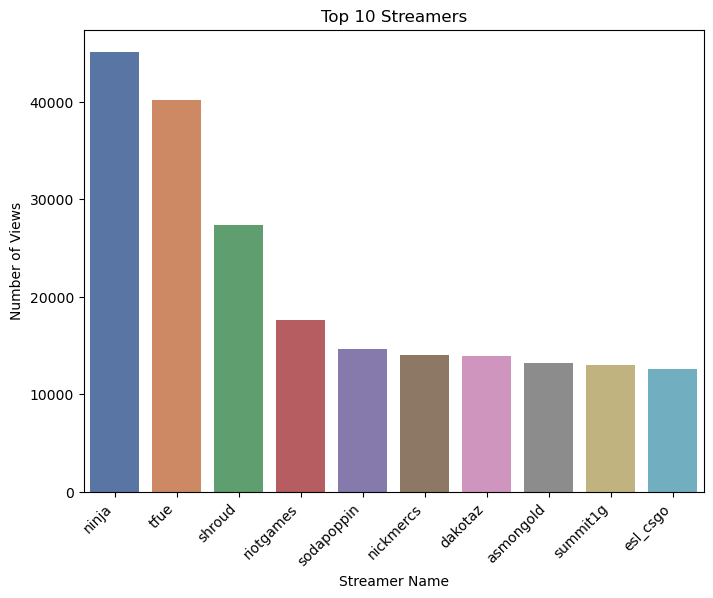

In [67]:
# Most popular streamers
sorted_streamer_views = dict(sorted(streamerViews.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(8,6))
sns.barplot(x=list(sorted_streamer_views.keys())[:10], y=list(sorted_streamer_views.values())[:10], palette='deep')
plt.title('Top 10 Streamers')
plt.xlabel('Streamer Name')
plt.ylabel('Number of Views')
plt.xticks(rotation=45, ha='right')

/Users/garrettlam/miniconda3/envs/cse158/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/garrettlam/miniconda3/envs/cse158/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Number of Interactions')

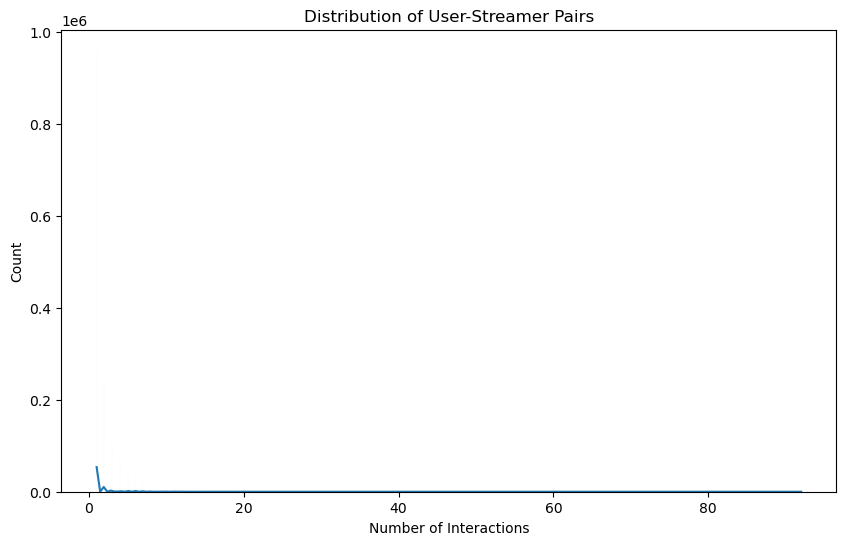

In [87]:
# Distribution of user_streamer pairs (How often a user watches a stream?)

plt.figure(figsize=(10, 6))
sns.histplot(list(interactionCount.values()), kde=True)
plt.title('Distribution of User-Streamer Pairs')
plt.xlabel('Number of Interactions')

/Users/garrettlam/miniconda3/envs/cse158/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/garrettlam/miniconda3/envs/cse158/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Number of Unique Streamers Watched by User')

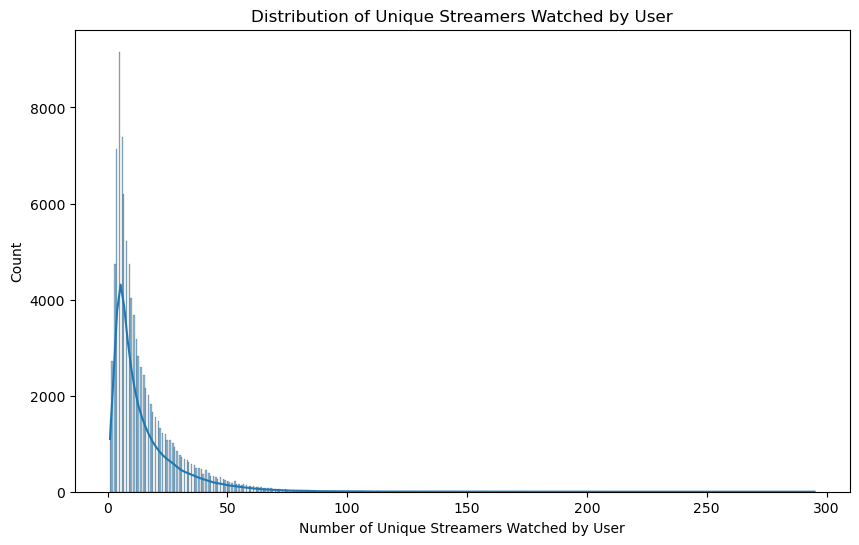

In [103]:
# Distribution of number of unique streamers watched by user
nUniqueStreamersPerUser = defaultdict(int)

for user,streamers in streamerPerUser.items():
    nUniqueStreamersPerUser[user] += len(streamers)

plt.figure(figsize=(10, 6))
sns.histplot(list(nUniqueStreamersPerUser.values()), kde=True)
plt.title('Distribution of Unique Streamers Watched by User')
plt.xlabel('Number of Unique Streamers Watched by User')

/Users/garrettlam/miniconda3/envs/cse158/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/garrettlam/miniconda3/envs/cse158/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Time (minutes)')

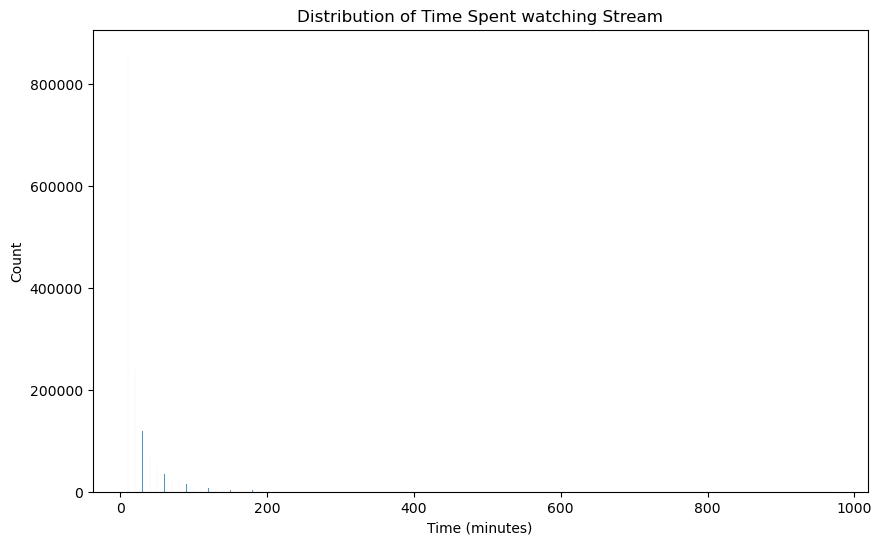

In [101]:
# distribution of time spent
plt.figure(figsize=(10, 6))
sns.histplot(list(timeDict.values()))
plt.title('Distribution of Time Spent watching Stream')
plt.xlabel('Time (minutes)')

# Models

### Popularity

In [15]:
streamerPerUser = defaultdict(set)
usersPerStreamer = defaultdict(set)
streamerPopularity = defaultdict(int)
timeDict = {}

for index, row in train.iterrows():
    user = row['user_id']
    streamer = row['streamer name']
    time = row['time spent']
    streamerPerUser[user].add(streamer)
    usersPerStreamer[streamer].add(user)
    streamerPopularity[streamer] += 1
    timeDict[(user,streamer)] = time

In [16]:
print(streamerPerUser[1])
usersPerStreamer['berkriptepe']

{'unlostv', 'grimnax', 'kendinemuzisyen', 'ogrencievi', 'elraenn', 'wtcn', 'zeon', 'jahrein', 'towshun', 'raufbaba25', 'mithrain', 'jrokezftw', 'zeusidiouss'}


{92,
 600,
 691,
 719,
 771,
 850,
 1126,
 1656,
 2086,
 2321,
 2504,
 2592,
 2606,
 2610,
 2614,
 3004,
 3805,
 3988,
 5701,
 5762,
 5928,
 5934,
 6140,
 6857,
 6867,
 6915,
 7399,
 7428,
 7582,
 7770,
 7845,
 8009,
 8391,
 8393,
 8400,
 8698,
 8699,
 8996,
 9207,
 9423,
 9429,
 9446,
 9575,
 9676,
 10010,
 10019,
 10157,
 10743,
 11428,
 11666,
 12100,
 12666,
 12807,
 12841,
 12910,
 12976,
 13007,
 13014,
 13029,
 13039,
 13096,
 13582,
 14297,
 14348,
 14475,
 14522,
 16632,
 17374,
 17575,
 18579,
 20355,
 20600,
 20662,
 20671,
 20881,
 21052,
 21814,
 21920,
 22379,
 22381,
 23174,
 23514,
 23800,
 24585,
 25528,
 25542,
 25544,
 25648,
 25649,
 25815,
 26075,
 26119,
 26121,
 26306,
 26381,
 26392,
 26486,
 26758,
 26774,
 26784,
 26877,
 27370,
 27631,
 27680,
 28312,
 28343,
 28546,
 29396,
 30269,
 30304,
 30308,
 31507,
 31775,
 31898,
 32695,
 33002,
 33878,
 34078,
 34450,
 34460,
 34567,
 34937,
 34945,
 35468,
 36953,
 38717,
 41007,
 41393,
 43430,
 43538,
 43565,
 44

In [17]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

In [18]:
sim = []
threshold = 0.025
count=0
prediction = 0

for index, row in test.iterrows():
    count +=1
    user = row['user_id']
    streamer = row['streamer name']
    s_ = streamerPerUser[user]
    currMax = float('-inf')
    for streamers in s_:
        currScore = Jaccard(usersPerStreamer[streamers],usersPerStreamer[streamer])
        if(currScore > currMax):
            currMax = currScore
        if(currMax == 1):
            prediction +=1
            break
    if(count % 10000 == 0):
        print('here in: ', count)
    sim.append(currMax)

print('here')

# for i in sim:
#     print(i)
#     if i == 1:
#         prediction +=1
        
acc = prediction/len(sim)
print(acc)

here in:  10000
here in:  20000
here in:  30000
here in:  40000
here in:  50000
here in:  60000
here in:  70000
here in:  80000
here in:  90000
here in:  100000
here in:  110000
here in:  120000
here in:  130000
here in:  140000
here in:  150000
here in:  160000
here in:  170000
here in:  180000
here in:  190000
here in:  200000
here in:  210000
here in:  220000
here in:  230000
here in:  240000
here in:  250000
here in:  260000
here in:  270000
here in:  280000
here in:  290000
here in:  300000
here in:  310000
here in:  320000
here in:  330000
here in:  340000
here in:  350000
here in:  360000
here in:  370000
here in:  380000
here in:  390000
here in:  400000
here in:  410000
here in:  420000
here in:  430000
here in:  440000
here in:  450000
here in:  460000
here in:  470000
here in:  480000
here in:  490000
here in:  500000
here in:  510000
here in:  520000
here in:  530000
here in:  540000
here in:  550000
here in:  560000
here in:  570000
here in:  580000
here in:  590000
here i